
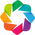

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import datetime 
from datetime import timedelta
import seaborn as sns 
from scipy import stats
from scipy.stats import norm
from scipy.stats import skew
sns.set(style = "whitegrid", color_codes = True)
sns.set(font_scale = 1)
from itertools import tee

from utils.bollinger_band import bollinger_bands, rolling_mean, rolling_std, candlestick
from utils.utils import get_data_frame_for_symbols, get_data_frame, spy_data_frame, pairwise, plot_normalize_data
from utils.get_stats import get_stocks_stas, compute_daily_return, stas_vs_indice

import holoviews as hv
hv.extension('bokeh')

## Portfolio simulation

In [2]:
def get_order(order_file):
    order = pd.read_csv(order_file,  
                        parse_dates=True)
    order.set_index("Date", inplace=True)
    return order

In [3]:
def portfolio_simulation(order_file, start, end, initial_captital=0):
    stocks = []
    order_list = get_order(order_file)
    # compute the volume
    order_list["Volumn"] = order_list.apply(lambda row: row["Volumn"] if (row["Order"] == "BUY" or row['Order'] == "SELL_SHORT") else -row["Volumn"] , axis=1)
    order_list = order_list.groupby(["Date", "Ticker"]).sum()
    order_list.reset_index(inplace=True)
    order_list.set_index(["Date"], inplace=True)
    
    # extrat the ticker list
    tickers_list = set(order_list["Ticker"].values)
    
    for ticker in tickers_list:
        # get the closing price of a given equity
        closing_price = get_data_frame(ticker, start, end, dropna= True)[ticker]
        
        # get the vol of a given equity
        order = order_list[order_list["Ticker"] == ticker]["Volumn"]
        
        # concat and align the closing price and the order volume
        equity = pd.concat(closing_price.align(order, fill_value=0), axis=1)
        equity.columns = [ticker, ticker+'_vol']
        stocks.append(equity)

    # concat all
    df = pd.concat(stocks, axis=1)

    for ticker in tickers_list:
        df[ticker+"_cumvol"] = df[ticker+"_vol"].cumsum()
        df[ticker+"_value"] = df[ticker] * df[ticker+"_cumvol"]
        df[ticker+"_order"] = df[ticker+"_vol"] * df[ticker]

    df["portfolio_value"] = df.filter(regex="value").sum(axis=1)
    df["order_value"] = df.filter(regex="order").sum(axis=1)
    
    # compute the capital
    df["capital"] = 0
    for i,row in df.iterrows():
        initial_captital -= row["order_value"]
        df.loc[i, "capital"] = initial_captital

    return df

## Back testing strategie 1: bollinger strategie

In [4]:
start_date = '2016-01-01'
end_date = '2016-12-31'
df = portfolio_simulation("order/orders_bollingerstrategy.txt", start_date, end_date, initial_captital= 100000)

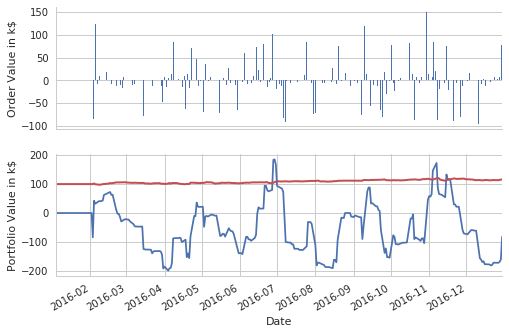

In [5]:
sns.set_style("whitegrid")

macro_df = df[["portfolio_value","order_value","capital"]].copy()
macro_df["portfolio_value"] = macro_df["portfolio_value"]/1000
macro_df["order_value"] = macro_df["order_value"]/1000
macro_df["portfolio_capital"] = macro_df["portfolio_value"] + macro_df["capital"]/1000

f, axarr = plt.subplots(2)

macro_df["order_value"].plot(kind='bar', ax=axarr[0])
macro_df["portfolio_value"].plot(ax=axarr[1])
macro_df["portfolio_capital"].plot(ax=axarr[1], lw=2, color='r')
axarr[0].set_xticks([])
axarr[0].set_ylabel("Order Value in k$")
axarr[1].set_ylabel("Portfolio Value in k$")
axarr[1].set_xlabel("Date")
axarr[1].spines['top'].set_visible(False)
axarr[1].spines['right'].set_visible(False)
axarr[0].spines['top'].set_visible(False)
axarr[0].spines['right'].set_visible(False)

In [6]:
%%opts Curve.Main.Portfolio [width=700 height=400 show_frame=False tools=['hover']] (color='k' line_width=3)
%%opts Curve.Main.Capital [width=700 height=400 show_frame=False tools=['hover']] (color='r' line_width=3)
#%%opts Spikes.Main.Order [width=700 height=400 show_frame=False tools=['hover']] (color='g' line_width=3)

macro_df = df[["portfolio_value","order_value","capital"]].copy()
macro_df.index.names = ['date']
macro_df.reset_index(inplace=True)
macro_df["capital_portfolio"] = (macro_df["capital"] + macro_df["portfolio_value"])/1000
macro_df["portfolio_value"] = macro_df["portfolio_value"] / 1000
macro_df["order_value"] = macro_df["order_value"] / 1000

key_dimensions   = [("date", "Date")]
value_dimensions = [('portfolio_value', 'Portfolio in k$'), 
                    ('order_value', 'Order in k$'), 
                    ("capital_portfolio", "Capital + Portfolio in k$")]

macro = hv.Table(macro_df, kdims=key_dimensions, vdims=value_dimensions)

portfolio_curves = macro.to(hv.Curve, kdims=['Date'], vdims=['Portfolio in k$'], group='Main', label='Portfolio')
capital_portfolio_curves = macro.to(hv.Curve, kdims=['Date'], vdims=['Capital + Portfolio in k$'], group='Main', label='Capital')
portfolio_curves * capital_portfolio_curves

:Overlay
   .Main.Portfolio :Curve   [date]   (portfolio_value)
   .Main.Capital   :Curve   [date]   (capital_portfolio)

In [7]:
print ("Return of our portfolio :{}%".format(((df.iloc[-1,-1]+ df.portfolio_value[-1])/df.capital[1] - 1)*100))

Return of our portfolio :16.373235799999986%


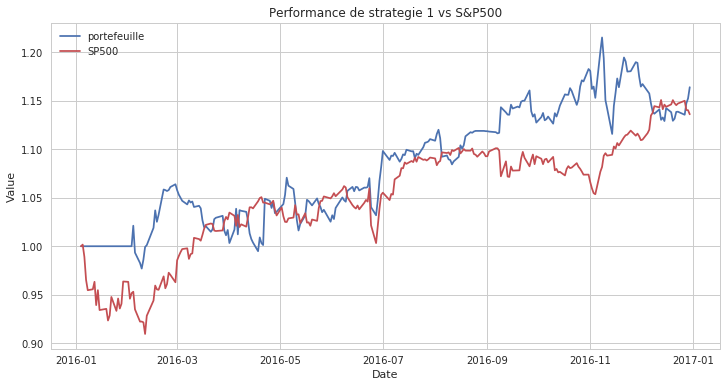

In [8]:
performace = df.capital + df.portfolio_value
plot_normalize_data(performace, start_date, end_date, title = "Performance de strategie 1 vs S&P500")
plt.savefig('figure/strategy1/perf_st1')

In [9]:
stas_vs_indice(performace, start_date, end_date)

,avg_daily_return,std_daily_return,beta,alpha,momentum,infor_ratio,sharpe_ratio
porfolio,0.000651,0.009664,0.037986,0.000630,0.029708,0.179839,1.068712
indice,0.000458,0.008205,0.997513,-0.000082,-0.014478,-0.160910,0.885999


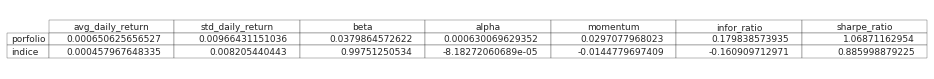

In [67]:
from pandas.tools.plotting import table

df = stas_vs_indice(performace, start_date, end_date)
fig, ax = plt.subplots(figsize=(15, 1.2)) 
ax.set_frame_on(False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

tab = table(ax, df , loc ="center")  
#tab.auto_set_font_size(False) # Activate set fontsize manually
#tab.set_fontsize(15) # if ++fontsize is necessary ++colWidths
tab.scale(1.05, 1.05) # change size table
plt.savefig('figure/strategy1/stas_strategy1_vs_indice')

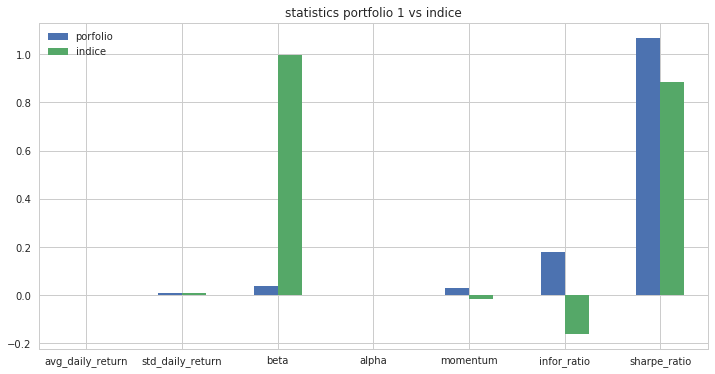

In [80]:
df.T.plot(kind = 'bar', rot = 0, figsize= (12,6), title= 'statistics portfolio 1 vs indice')
plt.savefig('figure/strategy1/statistics_portfolio_1_vs_indice_graph')

## Back testing strategie 2: bollinger strategie with momentum

In [10]:
start_date = '2016-01-01'
end_date = '2016-12-31'
df2 = portfolio_simulation("order/orders_strategy_2.txt", start_date, end_date, initial_captital= 100000)

In [11]:
%%opts Curve.Main.Portfolio [width=700 height=400 show_frame=False tools=['hover']] (color='k' line_width=3)
%%opts Curve.Main.Capital [width=700 height=400 show_frame=False tools=['hover']] (color='r' line_width=3)
#%%opts Spikes.Main.Order [width=700 height=400 show_frame=False tools=['hover']] (color='g' line_width=3)

macro_df = df2[["portfolio_value","order_value","capital"]].copy()
macro_df.index.names = ['date']
macro_df.reset_index(inplace=True)
macro_df["capital_portfolio"] = (macro_df["capital"] + macro_df["portfolio_value"])/1000
macro_df["portfolio_value"] = macro_df["portfolio_value"] / 1000
macro_df["order_value"] = macro_df["order_value"] / 1000

key_dimensions   = [("date", "Date")]
value_dimensions = [('portfolio_value', 'Portfolio in k$'), 
                    ('order_value', 'Order in k$'), 
                    ("capital_portfolio", "Capital + Portfolio in k$")]

macro = hv.Table(macro_df, kdims=key_dimensions, vdims=value_dimensions)

portfolio_curves = macro.to(hv.Curve, kdims=['Date'], vdims=['Portfolio in k$'], group='Main', label='Portfolio')
capital_portfolio_curves = macro.to(hv.Curve, kdims=['Date'], vdims=['Capital + Portfolio in k$'], group='Main', label='Capital')
portfolio_curves * capital_portfolio_curves

:Overlay
   .Main.Portfolio :Curve   [date]   (portfolio_value)
   .Main.Capital   :Curve   [date]   (capital_portfolio)

In [12]:
print ("Return of our portfolio :{}%".format(((df2.iloc[-1,-1]+ df2.portfolio_value[-1])/df.capital[1] - 1)*100))

Return of our portfolio :23.071711900000057%


In [13]:
performace2 = df2.capital + df2.portfolio_value

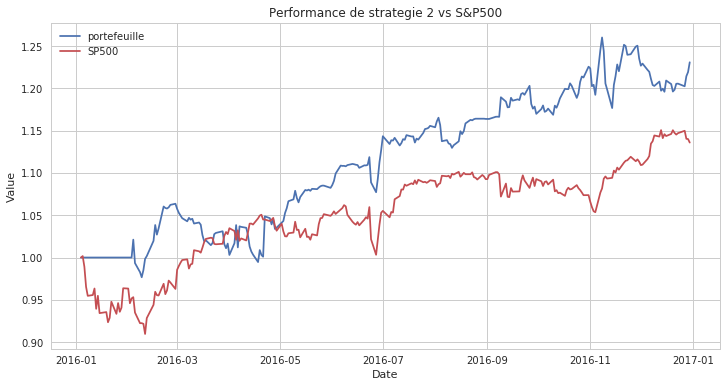

In [14]:
plot_normalize_data(performace2, start_date, end_date, title = "Performance de strategie 2 vs S&P500")
plt.savefig('figure/strategy2/perf_st2')

In [15]:
stas_vs_indice(performace2, start_date, end_date)

,avg_daily_return,std_daily_return,beta,alpha,momentum,infor_ratio,sharpe_ratio
porfolio,0.000868,0.009072,0.095370,0.000817,0.028046,0.572261,1.519137
indice,0.000458,0.008205,0.997513,-0.000082,-0.014478,-0.160910,0.885999


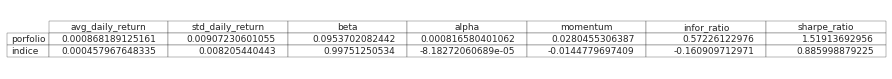

In [68]:
df2 = stas_vs_indice(performace2, start_date, end_date)
fig, ax = plt.subplots(figsize=(15, 1.2)) 
ax.set_frame_on(False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

tab = table(ax, df2 , loc ="center")  
#tab.auto_set_font_size(False) # Activate set fontsize manually
#tab.set_fontsize(15) # if ++fontsize is necessary ++colWidths
tab.scale(1, 1) # change size table
plt.savefig('figure/strategy2/stas_strategy2_vs_indice')

In [70]:
df2.T

,porfolio,indice
avg_daily_return,0.000868,0.000458
std_daily_return,0.009072,0.008205
beta,0.095370,0.997513
alpha,0.000817,-0.000082
momentum,0.028046,-0.014478
infor_ratio,0.572261,-0.160910
sharpe_ratio,1.519137,0.885999


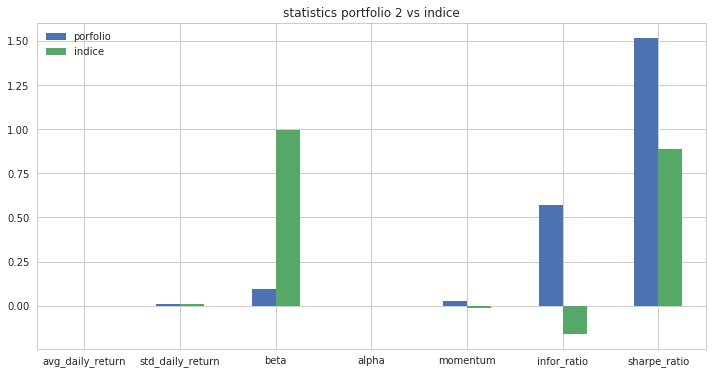

In [79]:
df2.T.plot(kind = 'bar', rot = 0, figsize= (12,6), title= 'statistics portfolio 2 vs indice')
plt.savefig('figure/strategy2/statistics_portfolio_2_vs_indice_graph')